<a href="https://colab.research.google.com/github/xahrahgh/Kalman_Filter_Intelligent_Navigation_Lab/blob/main/Lab2_Kalman_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Task 2.4:

In [ ]:
def GenerateData(N, Ts, sigma2q, sigma2r):

  x = np.zeros((2, N))   # state = [position; speed]
  x[:, 0] = [0, 0]       # initial state

  A = np.array([[1, Ts], [0, 1]])
  G = np.array([[Ts**2/2], [Ts]])

  a = np.random.normal(0.0, np.sqrt(sigma2q), N) # process noise
  for ii in range(N-1): # simulate system dynamics
    x[:, ii+1] = A @ x[:, ii] + G.T * a[ii]

  d = np.random.normal(0.0, np.sqrt(sigma2r), N) # measurement noise
  y = x[0, :] + d  # position measurements

  return x, y

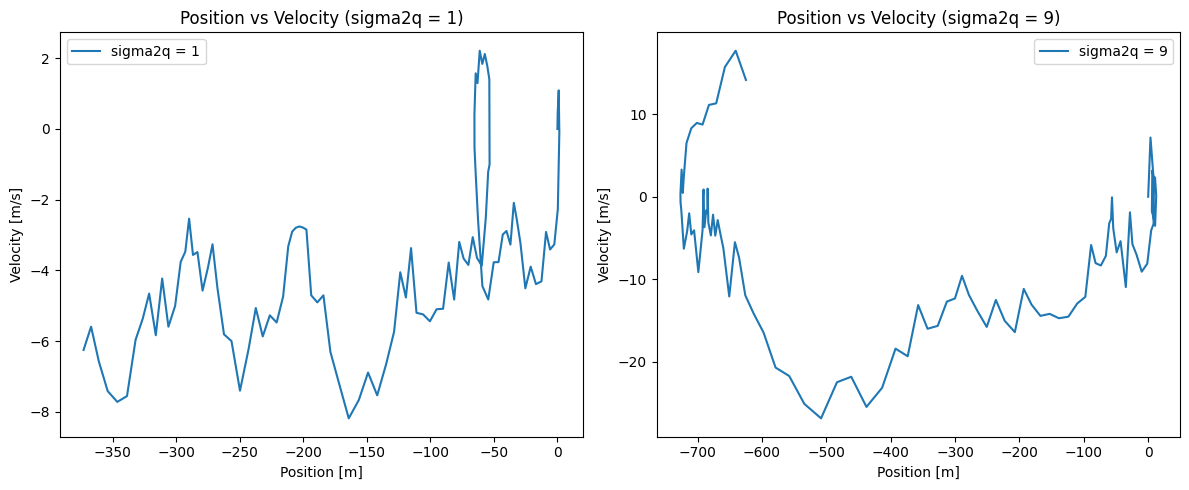

In [ ]:
# Simulation parameters
N = 100         # Number of time steps
Ts = 1          # Sampling time
sigma2r = 1     # Measurement noise variance

# Simulate for sigma2q = 1 and sigma2q = 9
sigma2q_cases = [1, 9]
data_sets = []

for sigma2q in sigma2q_cases:
    x, y = GenerateData(N, Ts, sigma2q, sigma2r)
    data_sets.append((x, y))

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (x, y) in enumerate(data_sets):
    axes[i].plot(x[0, :], x[1, :], label=f"sigma2q = {sigma2q_cases[i]}")
    axes[i].set_title(f"Position vs Velocity (sigma2q = {sigma2q_cases[i]})")
    axes[i].set_xlabel("Position [m]")
    axes[i].set_ylabel("Velocity [m/s]")
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

class KalmanFilter:
    def __init__(self, A, B, G, C, Q_m, R_m, initial_state=None, initial_covariance=None):
        """Initialize Kalman Filter with system matrices and initial conditions."""
        self.A = np.array(A)
        self.B = np.array(B)
        self.G = np.array(G)
        self.C = np.array(C)
        self.Q_m = np.array(Q_m)
        self.R_m = np.array(R_m)
        self.num_states = A.shape[0]

        # Initialize state estimate
        self.x = (initial_state.reshape(-1, 1) if initial_state is not None
                 else np.zeros((self.num_states, 1)))

        # Initialize covariance
        self.P = (initial_covariance if initial_covariance is not None
                 else np.eye(self.num_states))

        # Initialize histories
        self.state_history = []
        self.gain_history = []
        self.P_pred_history = []
        self.P_history = []

        # Initialize prediction storage
        self.x_pred = None
        self.P_pred = None

    @staticmethod
    def generate_data(N, Ts, sigma2q, sigma2r, initial_state=None):
        """
        Generate synthetic data for testing the Kalman filter.

        Parameters:
        -----------
        N : int
            Number of time steps
        Ts : float
            Sampling time
        sigma2q : float
            Process noise variance
        sigma2r : float
            Measurement noise variance
        initial_state : ndarray, optional
            Initial state vector [position; velocity]

        Returns:
        --------
        x : ndarray
            True states (2 × N)
        y : ndarray
            Noisy measurements (N,)
        system_matrices : dict
            Dictionary containing system matrices A, B, G, C and noise covariances
        """
        # Initialize state array
        x = np.zeros((2, N))
        x[:, 0] = initial_state if initial_state is not None else [0, 0]

        # System matrices
        A = np.array([[1, Ts], [0, 1]])
        G = np.array([[Ts**2/2], [Ts]])
        B = np.zeros((2, 1))  # No control input in this model
        C = np.array([[1, 0]])  # Measure only position

        # Generate process noise
        a = np.random.normal(0.0, np.sqrt(sigma2q), N)

        # Simulate system dynamics
        for ii in range(N-1):
            x[:, ii+1] = A @ x[:, ii] + G.flatten() * a[ii]

        # Generate measurements with noise
        d = np.random.normal(0.0, np.sqrt(sigma2r), N)
        y = x[0, :] + d

        # Create noise covariance matrices
        Q_m = G @ G.T * sigma2q
        R_m = np.array([[sigma2r]])

        # Package system matrices
        system_matrices = {
            'A': A,
            'B': B,
            'G': G,
            'C': C,
            'Q_m': Q_m,
            'R_m': R_m
        }

        return x, y, system_matrices

    def predict(self, control_input=None):
        """Perform prediction step."""
        # Handle control input
        u = (control_input.reshape(-1, 1) if control_input is not None
             else np.zeros((self.B.shape[1], 1)))

        # State prediction
        self.x_pred = self.A @ self.x + self.B @ u

        # Covariance prediction
        self.P_pred = self.A @ self.P @ self.A.T + self.Q_m

        # Store prediction
        self.P_pred_history.append(self.P_pred.copy())

        return self.x_pred, self.P_pred

    def update(self, measurement):
        """Perform update step with additional returns."""
        # Reshape measurement to column vector
        y = np.array(measurement).reshape(-1, 1)

        # Calculate innovation covariance
        S = self.C @ self.P_pred @ self.C.T + self.R_m

        # Calculate Kalman gain
        K = self.P_pred @ self.C.T @ np.linalg.inv(S)

        # Update state estimate
        innovation = y - self.C @ self.x_pred
        self.x = self.x_pred + K @ innovation

        # Update covariance
        I = np.eye(self.num_states)
        self.P = (I - K @ self.C) @ self.P_pred @ (I - K @ self.C).T + K @ self.R_m @ K.T

        # Store history
        self.state_history.append(self.x.copy())
        self.gain_history.append(K.copy())
        self.P_history.append(self.P.copy())

        return self.x, self.P, self.P_pred, K

    def filter_sequence(self, measurements, control_inputs=None):
        """Process a sequence of measurements."""
        num_steps = len(measurements)
        states = np.zeros((num_steps, self.num_states))

        for k in range(num_steps):
            # Get control input if provided
            u_k = control_inputs[k] if control_inputs is not None else None

            # Predict and update
            self.predict(u_k)
            _, _, _, _ = self.update(measurements[k])

            # Store state
            states[k] = self.x.flatten()

        return states, self.gain_history

In [ ]:
# Main simulation and plotting code
def run_simulation_and_filter(sigma2q, N=100, Ts=1.0, sigma2r=1.0):
    """Run single simulation and filtering."""
    # Generate data and initialize filter
    x_true, measurements, system_matrices = KalmanFilter.generate_data(N, Ts, sigma2q, sigma2r)
    kf = KalmanFilter(**system_matrices)  # Unpack matrices directly into constructor
    estimated_states, _ = kf.filter_sequence(measurements)
    return x_true, estimated_states, measurements

def plot_results(sigma2q_values):
    """Plot results for different sigma2q values."""
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    titles = ['Position', 'Velocity']

    for i, sigma2q in enumerate(sigma2q_values):
        true_states, est_states, measurements = run_simulation_and_filter(sigma2q)
        for j in range(2):
            ax = axs[i,j]
            ax.plot(true_states[j,:], 'b-', label='True state')
            ax.plot(est_states[:,j], 'r--', label='Estimated state')
            if j == 0:  # Only plot measurements for position
                ax.plot(measurements, 'g.', label='Measurements', alpha=0.5)
            ax.set_title(f'{titles[j]} (σ²q = {sigma2q})')
            ax.legend()
            ax.grid(True)

    plt.tight_layout()
    return fig

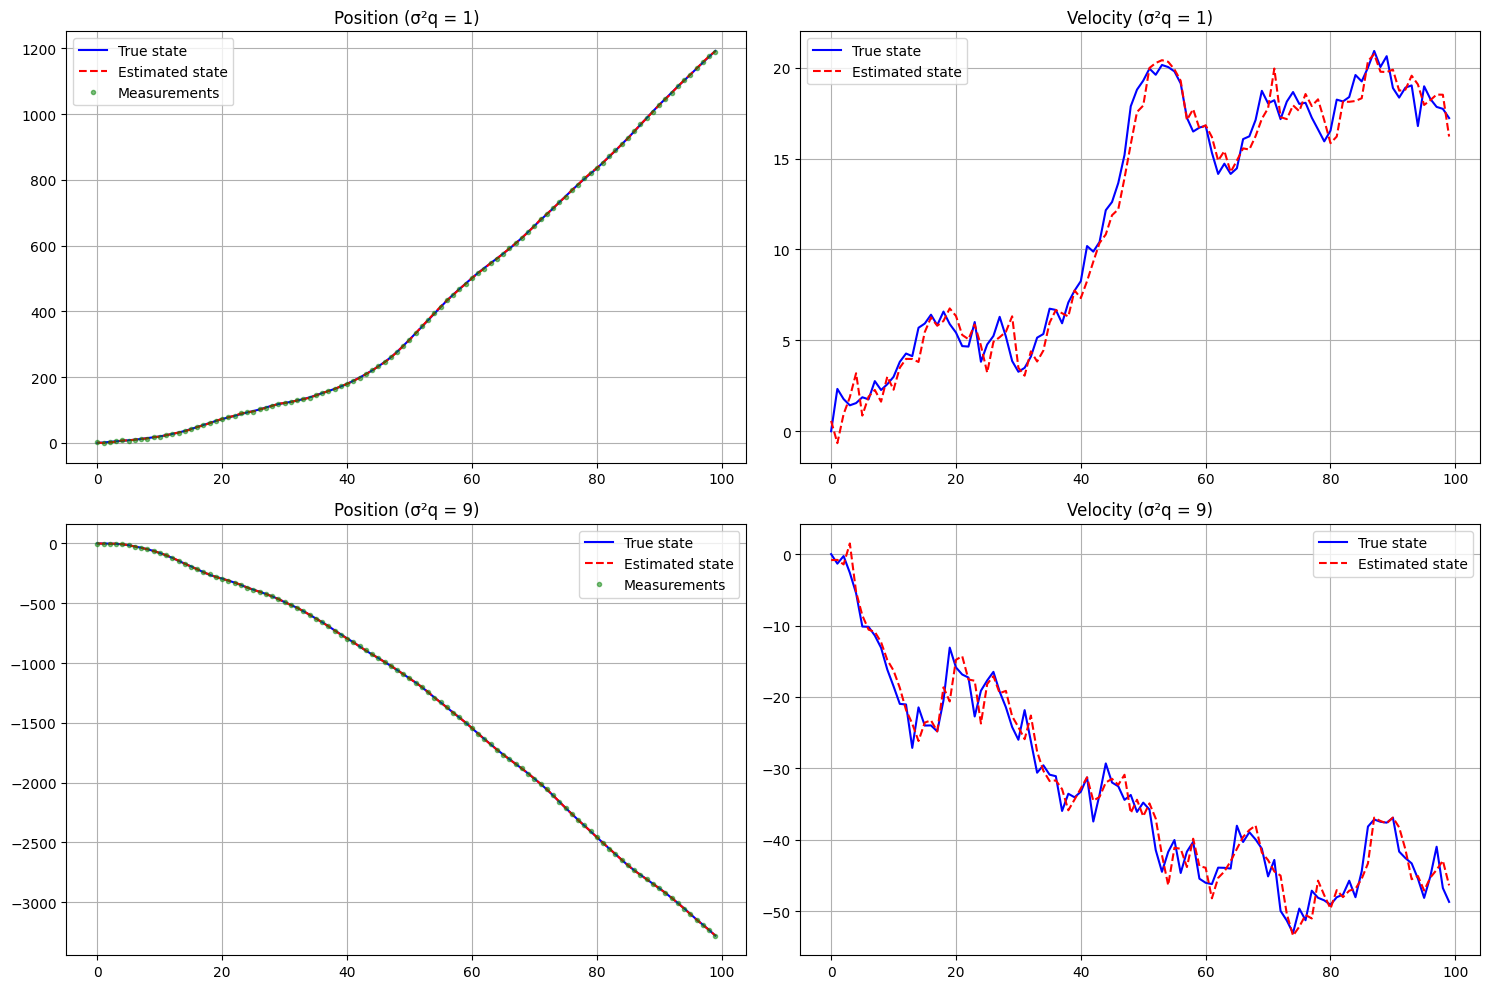

In [ ]:
sigma2q_values = [1, 9]
fig = plot_results(sigma2q_values)
plt.show()

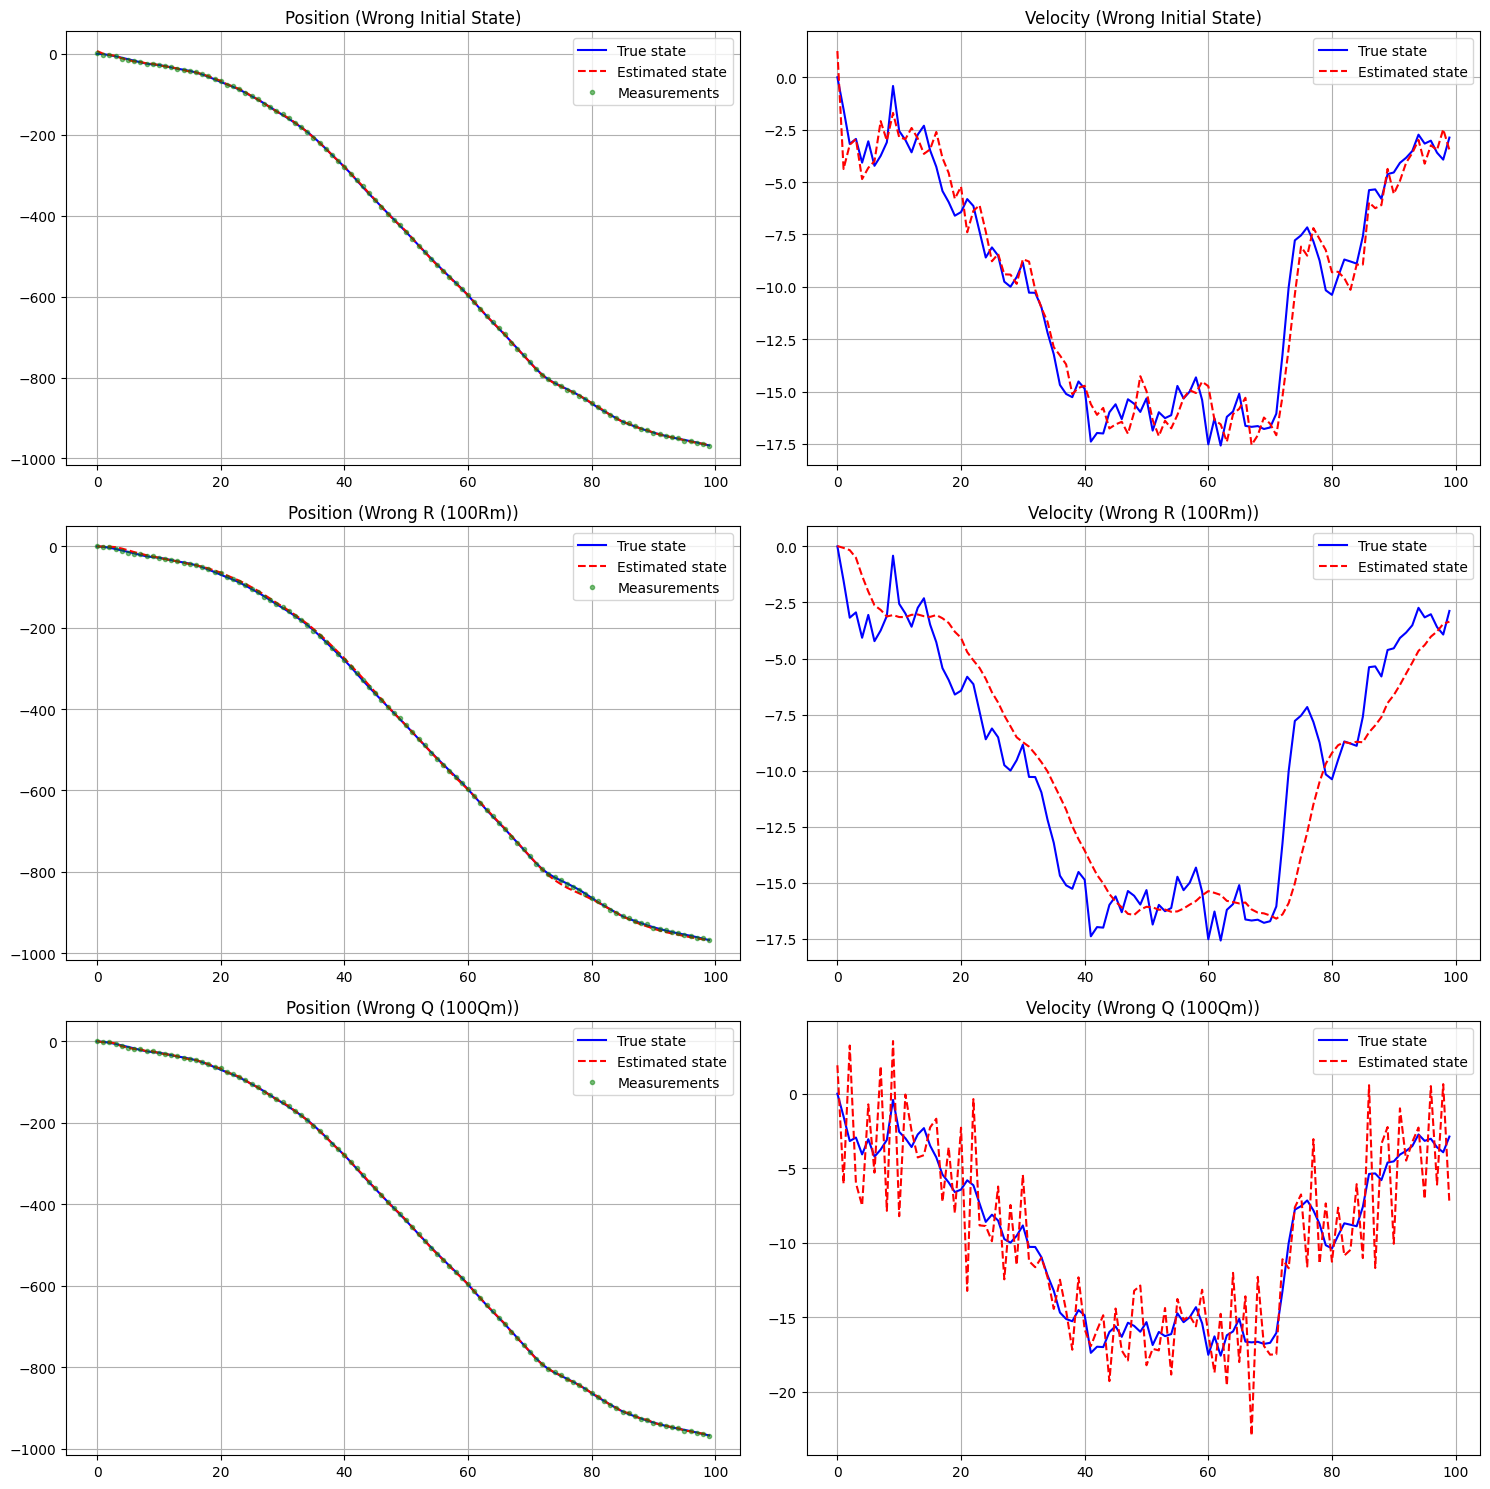

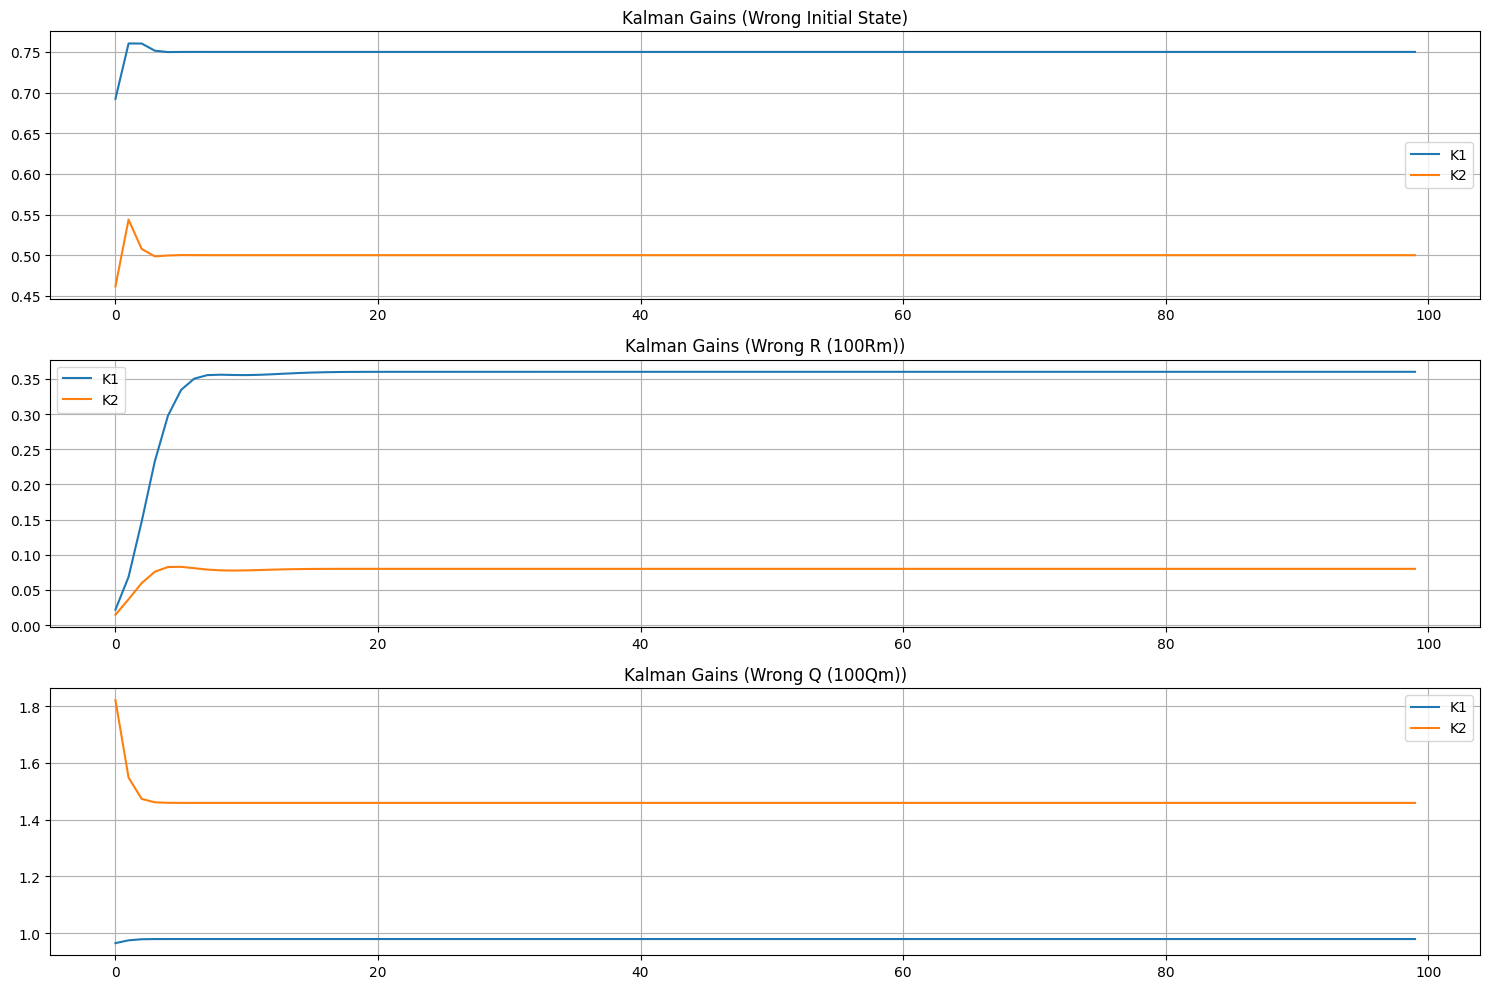

In [ ]:
def run_filter_scenarios():
    # Base parameters
    N = 100
    Ts = 1.0
    sigma2q = 1.0
    sigma2r = 1.0

    # Generate true data once to compare across scenarios
    x_true, measurements, system_matrices = KalmanFilter.generate_data(N, Ts, sigma2q, sigma2r)

    # Scenario 1: Wrong initial state
    kf1 = KalmanFilter(
        **system_matrices,
        initial_state=np.array([10, 10])  # Wrong initial state [10, 10]ᵀ
    )
    states1, gains1 = kf1.filter_sequence(measurements)

    # Scenario 2: Wrong measurement noise covariance
    kf2 = KalmanFilter(
        **{**system_matrices, 'R_m': 100 * system_matrices['R_m']}  # Rf = 100Rm
    )
    states2, gains2 = kf2.filter_sequence(measurements)

    # Scenario 3: Wrong process noise covariance
    kf3 = KalmanFilter(
        **{**system_matrices, 'Q_m': 100 * system_matrices['Q_m']}  # Qf = 100Qm
    )
    states3, gains3 = kf3.filter_sequence(measurements)

    return x_true, measurements, [(states1, gains1), (states2, gains2), (states3, gains3)]

# Run scenarios and plot results
x_true, measurements, scenarios = run_filter_scenarios()
scenario_names = ['Wrong Initial State', 'Wrong R (100Rm)', 'Wrong Q (100Qm)']
titles = ['Position', 'Velocity']

# Create plots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
for i, (states, gains) in enumerate(scenarios):
    for j in range(2):
        ax = axs[i,j]
        ax.plot(x_true[j,:], 'b-', label='True state')
        ax.plot(states[:,j], 'r--', label='Estimated state')
        if j == 0:  # Only plot measurements for position
            ax.plot(measurements, 'g.', label='Measurements', alpha=0.5)
        ax.set_title(f'{titles[j]} ({scenario_names[i]})')
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()

# Plot Kalman gains for each scenario
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
for i, (_, gains) in enumerate(scenarios):
    gains_array = np.array(gains)
    axs[i].plot(gains_array[:,0,0], label='K1')
    axs[i].plot(gains_array[:,1,0], label='K2')
    axs[i].set_title(f'Kalman Gains ({scenario_names[i]})')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def plot_filter_analysis(sigma2q_values):
    """Plot comprehensive analysis of filter behavior for different process noise values."""
    fig, axs = plt.subplots(3, 1, figsize=(12, 15))

    colors = ['b', 'r', 'g']

    for i, sigma2q in enumerate(sigma2q_values):
        results = analyze_filter_behavior(sigma2q)

        # Plot position variances (P₁₁)
        axs[0].plot(results['P_pred_pos'], f'{colors[i]}--',
                   label=f'P₁₁⁻ (σ²q={sigma2q})')
        axs[0].plot(results['P_est_pos'], f'{colors[i]}-',
                   label=f'P₁₁ (σ²q={sigma2q})')

        # Plot velocity variances (P₂₂)
        axs[1].plot(results['P_pred_vel'], f'{colors[i]}--',
                   label=f'P₂₂⁻ (σ²q={sigma2q})')
        axs[1].plot(results['P_est_vel'], f'{colors[i]}-',
                   label=f'P₂₂ (σ²q={sigma2q})')

        # Plot Kalman gains (K₁, K₂)
        axs[2].plot(results['K_pos'], f'{colors[i]}-',
                   label=f'K₁ (σ²q={sigma2q})')
        axs[2].plot(results['K_vel'], f'{colors[i]}--',
                   label=f'K₂ (σ²q={sigma2q})')

    # Customize plots
    axs[0].set_title('Position Variance Evolution (P₁₁)')
    axs[0].set_ylabel('P₁₁')
    axs[0].grid(True)
    axs[0].legend()

    axs[1].set_title('Velocity Variance Evolution (P₂₂)')
    axs[1].set_ylabel('P₂₂')
    axs[1].grid(True)
    axs[1].legend()

    axs[2].set_title('Kalman Gain Evolution (K₁, K₂)')
    axs[2].set_ylabel('K')
    axs[2].set_xlabel('Time Step')
    axs[2].grid(True)
    axs[2].legend()

    plt.tight_layout()
    return fig

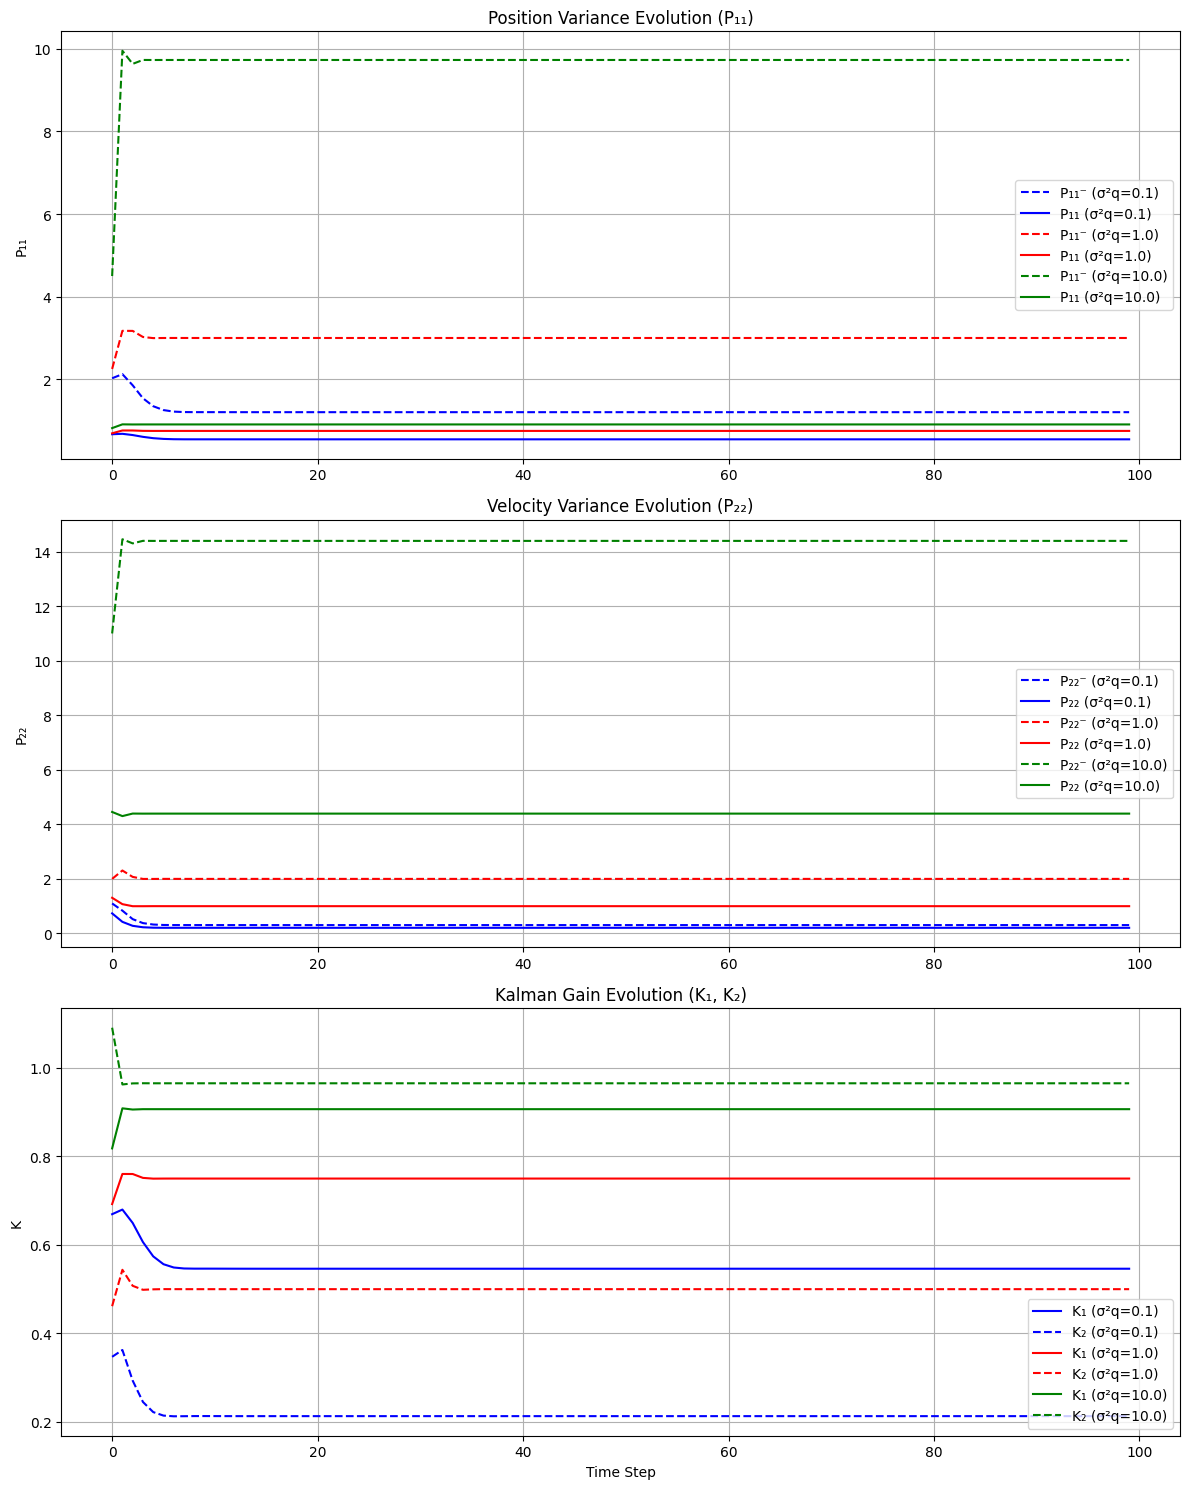

In [ ]:
# Run analysis with different process noise values
sigma2q_values = [0.1, 1.0, 10.0]
fig = plot_filter_analysis(sigma2q_values)
plt.show()

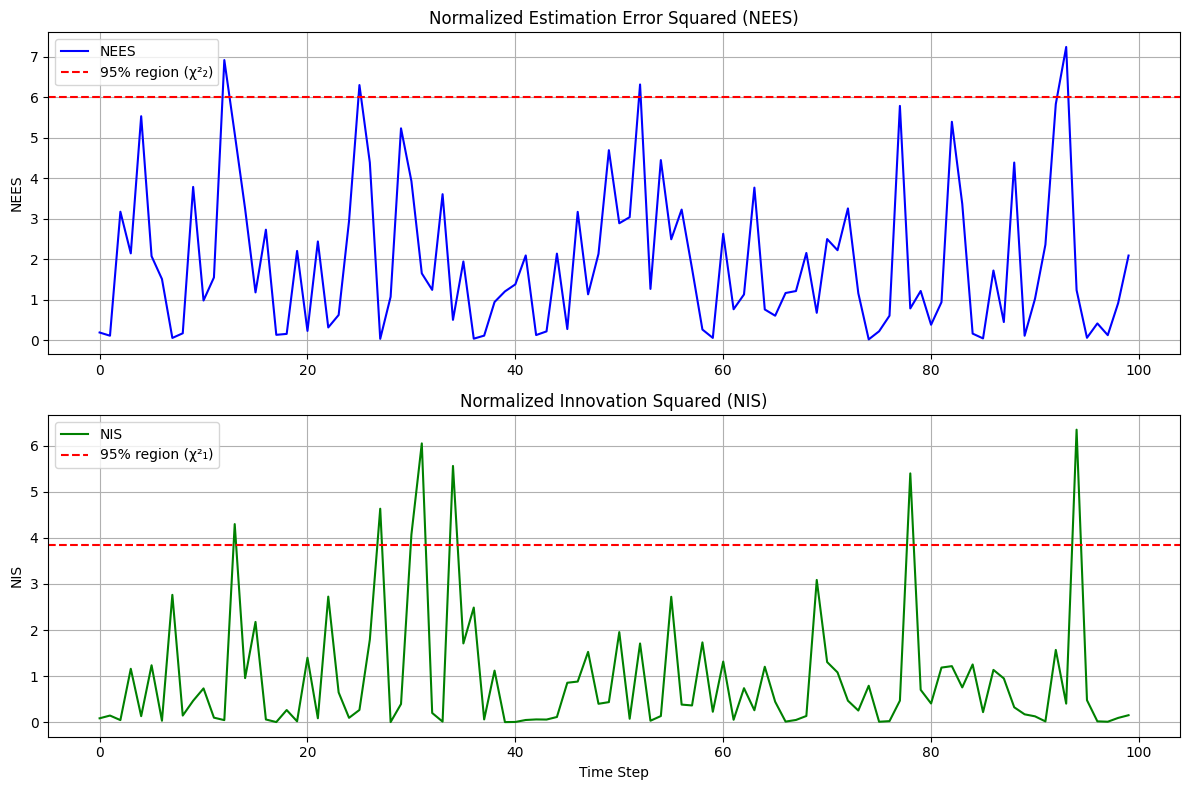

In [ ]:
def calculate_performance_indicators(x_true, measurements, kf):
    """Calculate NEES and NIS performance indicators."""
    N = len(measurements)
    nees_values = np.zeros(N)
    nis_values = np.zeros(N)

    for k in range(N):
        # Predict
        x_pred, P_pred = kf.predict()

        # Calculate NIS before update
        innovation = measurements[k] - kf.C @ x_pred
        S = kf.C @ P_pred @ kf.C.T + kf.R_m
        nis = innovation.T @ np.linalg.inv(S) @ innovation
        nis_values[k] = nis.item()

        # Update
        x_est, P_est, _, _ = kf.update(measurements[k])

        # Calculate NEES after update
        error = x_true[:, k].reshape(-1, 1) - x_est
        nees = error.T @ np.linalg.inv(P_est) @ error
        nees_values[k] = nees.item()

    return nees_values, nis_values

def plot_performance_indicators(nees_values, nis_values):
    """Plot NEES and NIS with probability regions."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Plot NEES
    ax1.plot(nees_values, 'b-', label='NEES')
    ax1.axhline(y=5.99, color='r', linestyle='--', label='95% region (χ²₂)')
    ax1.set_title('Normalized Estimation Error Squared (NEES)')
    ax1.set_ylabel('NEES')
    ax1.grid(True)
    ax1.legend()

    # Plot NIS
    ax2.plot(nis_values, 'g-', label='NIS')
    ax2.axhline(y=3.84, color='r', linestyle='--', label='95% region (χ²₁)')
    ax2.set_title('Normalized Innovation Squared (NIS)')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('NIS')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    return fig

# Run analysis
sigma2q = 1.0  # Process noise variance
N = 100        # Number of time steps
Ts = 1.0       # Sampling time
sigma2r = 1.0  # Measurement noise variance

# Generate data and initialize filter
x_true, measurements, system_matrices = KalmanFilter.generate_data(
    N, Ts, sigma2q, sigma2r)
kf = KalmanFilter(**system_matrices)

# Calculate performance indicators
nees_values, nis_values = calculate_performance_indicators(x_true, measurements, kf)

# Plot results
fig = plot_performance_indicators(nees_values, nis_values)
plt.show()